### Real wage growth explained by student debt

----

Brian Dew, @bd_econ


December 5, 2018


Originally posted on the bd econ blog, [here](https://briandew.wordpress.com/2018/12/05/student-debt-explains-why-wage-growth-hasnt-caused-inflation/)

In [1]:
import pandas as pd
import numpy as np
import wquantiles
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

import os

os.chdir('/home/brian/Documents/CPS/data/clean/')

file_dir = '/home/brian/Documents/Notebooks/'

In [2]:
cps_dir = '/home/brian/Documents/CPS/data/'

def binned_wage_calc(dfm, wage_var):
    """Return BLS-styled binned median wage"""
    wage_ranges = list(np.arange(1.5,3000,1))      
    dft = (dfm.sort_values(wage_var)
              .assign(WAGE_RANGE = (lambda x: pd.cut(x[wage_var], wage_ranges, 
                                           include_lowest=True)),
                      CS = lambda x: x['PWORWGT'].cumsum()))
    d = {}

    midpt = dft['PWORWGT'].sum() * 0.5
    mid_interval = dft.iloc[(dft['CS']-midpt).abs().argsort()[:1]].WAGE_RANGE.values[0]

    wage_bins = list(dft['WAGE_RANGE'].unique())

    mi_loc = wage_bins.index(mid_interval)
    lowval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc-1]].iloc[-1].CS
    highval = dft[dft['WAGE_RANGE'] == wage_bins[mi_loc]].iloc[-1].CS

    d['median'] = ((((midpt - lowval) / (highval - lowval)) * 0.5) + mid_interval.left)
    
    return(d)


In [3]:
wage_var = 'RWKWAGE'


cps_files = pd.Series([pd.to_datetime(file[:5], format='%b%y') 
                       for file in os.listdir(cps_dir) 
                       if file.endswith('pub.dat')])

years = list(set([file.year for file in cps_files]))

filter_cols = ['YEAR', 'MONTH', 'EDUC', wage_var, 'PWORWGT']

cps_date = lambda x: pd.to_datetime(
    dict(year=x.YEAR, month=x.MONTH, day=1))
df = pd.concat([
     (pd.read_feather(f'cps{year}.ft')
        .query('RWKWAGE > 0 and PRFTLF == 1 and 25 <= AGE <= 54')
        .filter(filter_cols)
        .assign(DATE = cps_date)
        .drop(['YEAR', 'MONTH'], axis=1)) 
     for year in years])

In [4]:
dt_windows = [pd.date_range(end=mo, periods=12, freq='MS') 
                  for mo in cps_files.sort_values()[11:]]

In [5]:
grps = [('Total, all workers', ['LTHS', 'HS', 'SC', 'COLL', 'ADV']), 
        ('High school degree\nor less', ['HS', 'LTHS']), 
        ('Some college or\nassociate degree', ['SC']), 
        ("Bachelor's degree\nor more" , ['COLL', 'ADV'])]

data = pd.DataFrame()

for grp in grps:
    educ_group = grp[1]
    d = df.query('EDUC in @educ_group')
    for dw in dt_windows:
        med_wage = binned_wage_calc(d[d['DATE'].isin(dw)], wage_var)
        data.at[dw[-1], grp[0]] = med_wage['median']

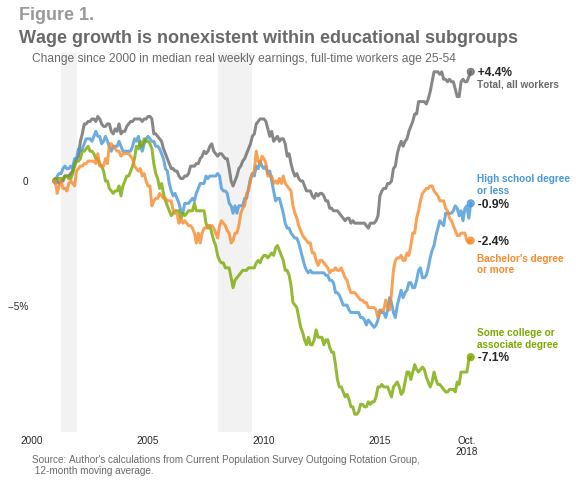

In [18]:
df1 = (((data.loc['2000-12-01':] / 
       data.loc['2000-12-01']) - 1) * 100).round(1)

color = ['dimgray', '#4897D8', '#7AA802', '#F78B2D']
offset = pd.DateOffset(months=4)

ax = df1.plot(figsize=(8, 7), color=color, linewidth=3, 
              legend=None, alpha=0.8)
ax = plt.xlim(df1.index[0] - offset, df1.index[-1] + offset)

ax = plt.scatter([df1.index[-1]] * len(df1.iloc[-1]), df1.iloc[-1], 
                 color=color, s=50, alpha=0.8)

# Recession start and end months, from NBER
for i, v in [('2001-04-01', '2001-12-01'), ('2008-01-01', '2009-07-01')]:
    ax = plt.axvspan(i, v, fill=True, linewidth=0, color='gray', alpha=0.1)
for s in df1.iloc[-1]:
    if s < 0:
        ax = plt.annotate(f'  {s:.1f}%', (df1.index[-1], s-0.15), fontsize=12, fontweight=600)
    else:
        ax = plt.annotate(f'  +{s:.1f}%', (df1.index[-1], s-0.15), fontsize=12, fontweight=600) 
names = list(df1.iloc[-1].keys())
locs = [3.8, -0.5, -6.7, -3.7] 
for i, v in enumerate(names):
    ax = plt.annotate(v, ('2019-03-01', locs[i]), fontsize=10, fontweight=800, color=color[i])
        
ticks = ['2000-01-01', '2005-01-01', '2010-01-01', '2015-01-01', '2018-12-01']
labels = ['2000', '2005', '2010', '2015', 'Dec.\n2018']
ax = plt.xticks(ticks, labels)
ax = plt.yticks([0, -5], ['0', '--5%'])
ax = plt.text('1999-06-01', 6.5, 'Figure 1.', 
              fontsize=18, fontweight=600, color='gray', alpha=0.8)
ax = plt.text('1999-06-01', 5.6, 'Wage growth is nonexistent within educational subgroups', 
              fontsize=18, fontweight=600, color='dimgray')
ax = plt.text('2000-01-01', 4.8, 'Change since 2000 in median real weekly earnings, full-time workers age 25-54', 
              fontsize=12, fontweight=400, color='dimgray')

ax = plt.text('2000-01-01', -11.8, "Source: Author's calculations from Current Population Survey Outgoing Rotation Group,\n 12-month moving average.", 
              fontsize=10, fontweight=400, color='dimgray')

plt.savefig(f'{file_dir}/Fig1.png', dpi=400, bbox_inches='tight', pad_inches=0.2)

#### Second chart

In [22]:
# Educational group share of total
r = (df.groupby(['DATE', 'EDUC']).PWORWGT.sum() / df.groupby(['DATE']).PWORWGT.sum()) * 100
df3 = pd.DataFrame()
for grp in grps[1:]:
    df3[grp[0]] = r.unstack()[grp[1]].sum(axis=1)

In [26]:
ln_tc = np.log(2884.61)
wage_ranges = list(np.arange(np.log(150), ln_tc, 0.1))

df = (df.assign(LN_WAGE = lambda x: np.log(x.RWKWAGE))
        .assign(WAGE_RANGE = (lambda x: pd.cut(x.LN_WAGE, wage_ranges, 
                                           include_lowest=True))))

comps = [('2000', (df['DATE'].dt.year == 2000)), 
         ('latest\n12 mos.', (df['DATE'] > '2017-10-01'))]

Manually loop through education groups and create dataframe

result3 = Bachelor's degree or more
result2 = Some college or associate degree
result1 = High school degree or less

In [38]:
ed_grp = grps[3][1]
ed_grp

['COLL', 'ADV']

In [39]:
result = pd.DataFrame()
notes = {}
for c in comps:
    print(c[0])
    data1 = df[c[1]]
    pop = data1.groupby('WAGE_RANGE').PWORWGT.sum().sum()
    data2 = df[df['EDUC'].isin(ed_grp) & c[1]]
    dis = (data2.groupby('WAGE_RANGE').PWORWGT.sum().rolling(2).mean())
    result[c[0]] = ((dis / pop) * 100).dropna()
    median = binned_wage_calc(data2, wage_var)
    tc = data1[(data1['EDUC'].isin(ed_grp)) & (data1['RWKWAGE'] >= 2884.61)]
    tc_sh = (tc.PWORWGT.sum() / pop) * 100
    print(tc_sh)
    notes[c[0]] = {'tc_sh': tc_sh, 'med': median}

2000
2.402950568229665
latest
12 mos.
2.6269437734351793


In [40]:
result['VALS'] = [i.right for i in result.reset_index()['WAGE_RANGE']]
result3 = result.set_index('VALS').loc[5.611:]

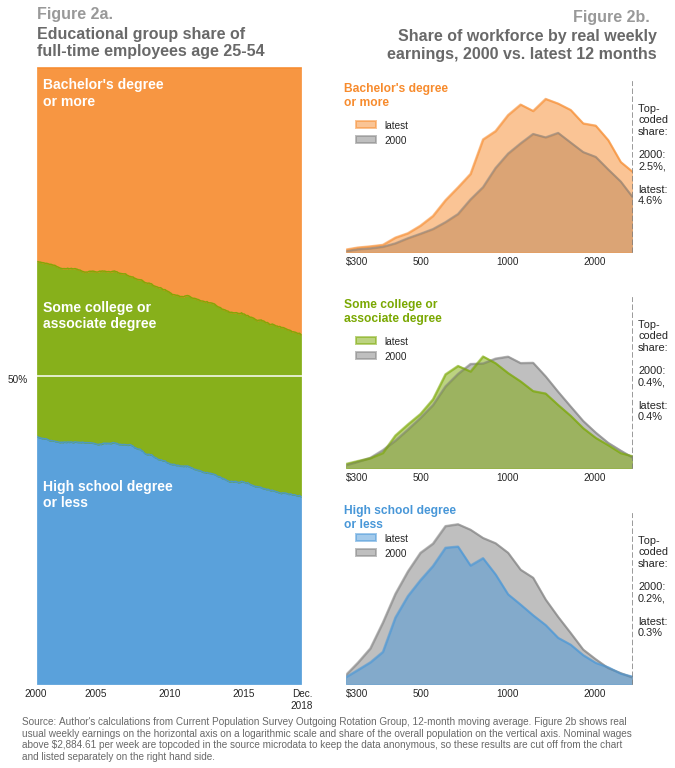

In [43]:
fig=plt.figure(figsize=(10, 10))
c=fig.add_axes((0.45,0.05,0.4,0.24)) # number here are coordinate (left,bottom,width,height)
b=fig.add_axes((0.45,0.35,0.4,0.24))
a=fig.add_axes((0.45,0.65,0.4,0.24))
t=fig.add_axes((0.02,0.05,0.37,0.9))

ax = (df3.loc['2000':].rolling(12).mean().loc['2000-12-01':].dropna()
         .plot.area(legend=False, color=color[1:], alpha=0.9, ax=t))

ticks = ['2000-12-01', '2005-01-01', '2010-01-01', '2015-01-01', '2018-12-01']
labels = ['2000', '2005', '2010', '2015', 'Dec.\n2018']
ax = plt.xticks(ticks, labels)
ax = plt.yticks([], [])
ax = plt.text('1999-01-01', 49, '50%')
#ax = plt.text('1998-09-01', 99, '100%')
ax = plt.text('2001-06-01', 94, grps[3][0], color='white', fontsize=14, fontweight=600)
ax = plt.text('2001-06-01', 58, grps[2][0], color='white', fontsize=14, fontweight=600)
ax = plt.text('2001-06-01', 29, grps[1][0], color='white', fontsize=14, fontweight=600)
ax = plt.axhline(50, color='white')
ax = plt.text('2001-01-01', 108, 'Figure 2a.', 
              fontsize=16, fontweight=600, color='gray', alpha=0.8)

ax = plt.text('2001-01-01', 102, 'Educational group share of\nfull-time employees age 25-54 ', 
              fontsize=16, fontweight=600, color='dimgray')
ax = plt.xlabel('')


# 
ax0 = result3.plot(kind='area', color=['gray', color[3]], linewidth=2, 
                   alpha=0.5, stacked=False, ax=a, legend=False)
ax0.set_ylim([0, 3.5])
ax0.text(5.6, 3, grps[3][0], color=color[3], fontsize=12, fontweight=600)
ax0.axvline(x=7.911, linestyle='dashed', color='dimgray')
ax0.set_xlabel('')
ticks = [np.log(300), np.log(500), np.log(1000), np.log(2000)]
labels = ['$300', '500', '1000', '2000']
ax0.set_xticks(ticks)
ax0.set_xticklabels(labels)
ax0.text(7.95, 1, 'Top-\ncoded\nshare:\n\n2000:\n2.5%,\n\nlatest:\n4.6%', rotation=0, fontsize=11)
ax0.set_yticks([])
ax0.set_yticklabels([])
legend_patch = mpatches.Patch(color=color[3], label='latest', linewidth=2, alpha=0.5)
patch_2k = mpatches.Patch(color='gray', label='2000', linewidth=2, alpha=0.5)
ax0.legend(bbox_to_anchor=(0.25, 0.82), handles=[legend_patch, patch_2k])


ax1 = result2.plot(kind='area', color=['gray', color[2]], linewidth=2, 
                   alpha=0.5, stacked=False, ax=b, legend=False)
ax1.set_ylim([0, 3.5])
ax1.text(5.6, 3, grps[2][0], color=color[2], fontsize=12, fontweight=600)
ax1.axvline(x=7.911, linestyle='dashed', color='dimgray')
ax1.set_xlabel('')
ax1.set_xticks(ticks)
ax1.set_xticklabels(labels)
ax1.text(7.95, 1, 'Top-\ncoded\nshare:\n\n2000:\n0.4%,\n\nlatest:\n0.4%', rotation=0, fontsize=11)
ax1.set_yticks([])
ax1.set_yticklabels([])
legend_patch = mpatches.Patch(color=color[2], label='latest', linewidth=2, alpha=0.5)
patch_2k = mpatches.Patch(color='gray', label='2000', linewidth=2, alpha=0.5)
ax1.legend(bbox_to_anchor=(0.25, 0.82), handles=[legend_patch, patch_2k])


ax2 = result1.plot(kind='area', color=['gray', color[1]], linewidth=2, 
                   alpha=0.5, stacked=False, ax=c, legend=False)
ax2.set_ylim([0, 3.5])
ax2.text(5.6, 3.2, grps[1][0], color=color[1], fontsize=12, fontweight=600)
ax2.axvline(x=7.911, linestyle='dashed', color='dimgray')
ax2.set_xlabel('')
ax2.set_xticks(ticks)
ax2.set_xticklabels(labels)
ax2.text(7.95, 1, 'Top-\ncoded\nshare:\n\n2000:\n0.2%,\n\nlatest:\n0.3%', rotation=0, fontsize=11)
ax2.set_yticks([])
ax2.set_yticklabels([])
legend_patch = mpatches.Patch(color=color[1], label='latest', linewidth=2, alpha=0.5)
patch_2k = mpatches.Patch(color='gray', label='2000', linewidth=2, alpha=0.5)
ax2.legend(bbox_to_anchor=(0.25, 0.68), handles=[legend_patch, patch_2k])


ax0.text(7.43, 4.7, 'Figure 2b.', 
         fontsize=16, fontweight=600, color='gray', alpha=0.8)

ax0.text(8.1, 3.95, 'Share of workforce by real weekly\nearnings, 2000 vs. latest 12 months', 
         fontsize=16, fontweight=600, color='dimgray', ha='right')


ax = plt.text('2000-01-01', -12, "Source: Author's calculations from Current Population Survey Outgoing Rotation Group, 12-month moving average. Figure 2b shows real\nusual weekly earnings on the horizontal axis on a logarithmic scale and share of the overall population on the vertical axis. Nominal wages\nabove $2,884.61 per week are topcoded in the source microdata to keep the data anonymous, so these results are cut off from the chart\nand listed separately on the right hand side.", 
              fontsize=10, fontweight=400, color='dimgray')

plt.savefig(f'{file_dir}/Fig2.png', dpi=400, bbox_inches='tight', pad_inches=0.2)
plt.show()